In [3]:
import pandas as pd
import random
import math
import operator
import numpy as np
from IPython.display import display, HTML

In [4]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


/Users/ando/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from matplotlib import gridspec

%matplotlib inline
plt.style.use('smandry')

In [6]:
class ModelStat(object):
    """
    Calculate model statistics:
    
    Example:
    
    >>> linreg = linear_model.LinearRegression()
    >>> linreg_stat = ModelStat(linreg, advertising[['TV']], advertising.Sales)
    >>> display(linreg_stat.results)
    """
    def __init__(self, model, X, y, fit=False, linear=True, cols=None, hypothesis=0):
        if fit:
            model.fit(X,y)
        self.model = model
        self.y = y
        self.nobs = X.shape[0]
        self.npred = X.shape[1]
        self.pred = model.predict(X)
        if isinstance(X, pd.DataFrame):
            newX = np.hstack((np.ones(self.nobs).reshape(-1,1), X.values))
            cols = ['Intercept']+list(X.columns)
            rankX = np.linalg.matrix_rank(X.values)
        else:
            newX = np.hstack((np.ones(self.nobs).reshape(-1,1), X))
            rankX = np.linalg.matrix_rank(X)
        self.dof = ModelStat.dof(X)
        self.RSS = ModelStat.rss(self.y, self.pred)
        self.MSE = ModelStat.mean_squared_error(self.y, self.pred, dof=self.dof)
        self.TSS = ModelStat.tss(self.y)
        self.rsquare = ModelStat.rsquare(self.y, self.pred)
        self.rsquare_adj = ModelStat.rsquare_adj(X, self.y, self.pred)
        model_name = str(model.__class__).replace("<class '","").replace("'>","")
        if model_name == "sklearn.linear_model.base.LinearRegression":
            self.params = np.append(model.intercept_,model.coef_)
            self.cov_params = ModelStat.cov_matrix(newX)
            variance = self.MSE * (self.cov_params.diagonal())
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(self.dof+1))) for i in self.tValues]
            tppf = sc.stats.t.isf(0.025, self.dof)
            self.confInt = [self.params-tppf*self.StdErr, self.params+tppf*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["tValues"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.975]"] = self.confInt[1]
            self.results = mydf
        if model_name == "sklearn.linear_model.logistic.LogisticRegression":
            self.params = np.append(model.intercept_,model.coef_)
            predictions = self.predict_proba(X)
            likelihood = np.multiply(predictions[:,0], predictions[:,1])
            self.cov_params = ModelStat.covlogit_matrix(newX, likelihood)
            variance = np.diag(covLogit)
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(self.dof+1))) for i in self.tValues]
            tppf = sc.stats.t.isf(0.025, self.dof)
            self.confInt = [self.params-tppf*self.StdErr, self.params+tppf*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["tValues"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.975]"] = self.confInt[1]
            self.results = mydf
                        
    @staticmethod
    def rss(y, ypred):
        return sum((y - ypred)**2)

    @staticmethod
    def tss(y):
        return sum((y - y.mean())**2)

    @staticmethod
    def dof(X):
        return X.shape[0] - np.linalg.matrix_rank(X) -1
    
    @staticmethod
    def mean_squared_error(y, ypred, dof=None):
        rss = ModelStat.rss(y, ypred)
        if not dof: 
            dof = len(y)
        return rss/float(dof)
    
    @staticmethod    
    def rsquare(y, ypred):
        return 1.0 - (ModelStat.rss(y, ypred)/ModelStat.tss(y))
    
    @staticmethod    
    def rsquare_adj(X, y, ypred):
        return 1.0 - ((ModelStat.rss(y, ypred)/ModelStat.tss(y))*((X.shape[0]-1)/float(X.shape[0]-X.shape[1]-1)))

    @staticmethod
    def cov_matrix(newX):
        return np.linalg.pinv(np.dot(newX.T, newX))

    @staticmethod
    def covlogit_matrix(newX, likelihood):
        V = np.matrix(np.zeros(shape = (newX.shape[0], newX.shape[0])))
        np.fill_diagonal(V, likelihood)
        return np.linalg.pinv((newX.T).dot(V).dot(newX))
    
    def prediction_band(self, xnew, alpha=0.05, cols=None):
        """
        Prediction interval of new X (x0)
        
        pred +/- t * sqrt (MSE * (1 + x0' (X'X)-1 x0 )) 
        http://academic.macewan.ca/burok/Stat378/notes/moremultiple.pdf
        """
        pred = self.model.predict(xnew)
        xnew = np.hstack((np.ones(len(xnew)).reshape(-1,1), xnew))
        predvar = self.MSE * (1.0 + (xnew * np.dot(self.cov_params, xnew.T).T).sum(1))
        predstd = np.sqrt(predvar)
        tppf = sc.stats.t.isf(alpha/2., self.dof)
        interval_u = pred + tppf * predstd
        interval_l = pred - tppf * predstd
        if not cols: 
            cols = ['X'+str(i) for i in np.arange(xnew.shape[1]-1)]
        table = pd.DataFrame(np.zeros((len(xnew), xnew.shape[1]-1)), columns = cols)            
        for i, col in enumerate(cols):
            table[col] = xnew[:,i+1]
        table['fit'] = pred
        table['pred_lwr'] = interval_l
        table['pred_upr'] = interval_u
        return table
    
    def confidence_band(self, xnew, alpha=0.05, cols=None):
        """
        Confidence interval of new X (x0)
        
        pred +/- t * sqrt (MSE * x0' (X'X)-1 x0 )) 
        http://academic.macewan.ca/burok/Stat378/notes/moremultiple.pdf
        """
        pred = self.model.predict(xnew)
        xnew = np.hstack((np.ones(len(xnew)).reshape(-1,1), xnew))
        last_term = np.dot(self.cov_params, xnew.T)
        pred_mean_se = np.sqrt(self.MSE * (xnew * last_term.T).sum(1))
        tppf = sc.stats.t.isf(alpha/2.0, self.dof)
        mean_u = pred + tppf * pred_mean_se
        mean_l = pred - tppf * pred_mean_se
        if not cols: 
            cols = ['X'+str(i) for i in np.arange(xnew.shape[1]-1)]
        table = pd.DataFrame(np.zeros((len(xnew), xnew.shape[1]-1)), columns = cols)            
        for i, col in enumerate(cols):
            table[col] = xnew[:,i+1]
        table['fit'] = pred
        table['conf_lwr'] = mean_l
        table['conf_upr'] = mean_u
        return table
        

def anova_lm(*args):
    """
    Anova table for fitted linear models. Input: Model statistics
    
    Example:
    >>> lin1 = ModelStat(linreg, Credit[['Limit']], Credit['Balance'], fit=True)
    >>> lin2 = ModelStat(linreg, Credit[['Limit', 'Age']], Credit['Balance'], fit=True)
    >>> anova_lm(lin1,lin2)
    
    """
    names = ['dof', 'rss', 'dof_diff', 'rss_diff', 'F', 'Pr(>F)']
    n_models = len(args)
    scale = args[-1].RSS/float(args[-1].dof)
    table = pd.DataFrame(np.zeros((n_models, 6)), columns = names)
    table["rss"] = list(map(getattr, args, ["RSS"]*n_models))
    table["dof"] = list(map(getattr, args, ["dof"]*n_models))
    table.loc[table.index[1:], "dof_diff"] = -np.diff(table["dof"].values)
    table["rss_diff"] = - table["rss"].diff()
    table["F"] = table["rss_diff"] / table["dof_diff"] / scale
    table["Pr(>F)"] = sc.stats.f.sf(table["F"], table["dof_diff"], table["dof"])
    return table

# This is the same as statsmodel :
# lm_fit = smf.ols('Balance ~ Limit', data=Credit).fit()
# lm_fit2 = smf.ols('Balance ~ Limit + Age', data=Credit).fit()
# sm.stats.anova_lm(lm_fit, lm_fit2, typ=1)

# lin1 = ModelStat(linreg, Credit[['Limit']], Credit['Balance'], fit=True)
# lin2 = ModelStat(linreg, Credit[['Limit', 'Age']], Credit['Balance'], fit=True)
# anova_lm(lin1,lin2)        
        
        
# Function for creating grid    
def grid_create(model, XX, y, xstd, ystd, ngrid=20):
    xar = np.linspace(model.coef_[0]- xstd, model.coef_[0]+xstd, ngrid)
    yar = np.linspace(model.coef_[1]- ystd, model.coef_[1]+ystd, ngrid)
    xarr, yarr = np.meshgrid(xar, yar, indexing='xy')
    Z = np.zeros((xar.size,yar.size))
    xz = np.transpose(XX[:,0])
    yz = np.transpose(XX[:,1])
    intercept = model.intercept_
    for (i,j),v in np.ndenumerate(Z):
        coef1 = xarr[i,j]
        coef2 = yarr[i,j]
        Z[i,j] =sum((y - (intercept + coef1*xz + coef2*yz))**2)
    return(xarr,yarr,Z)

# An Overview of Classification

In [7]:
df = pd.read_excel('Data/Default.xlsx')
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


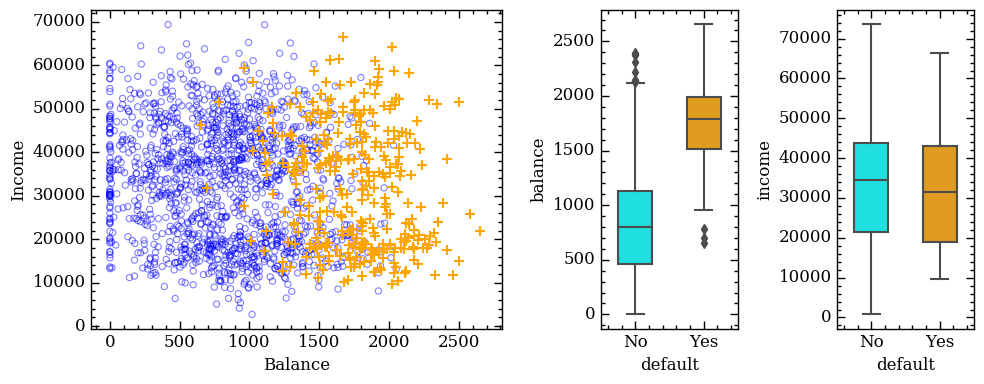

In [15]:
# Figure 4.1
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[3,1,1])
(ax1,ax2,ax3) = [plt.subplot(i) for i in gs]

subset_no = df[df.default == 'No'].sample(frac=0.15)
subset_yes = df[df.default == 'Yes']

ax1.scatter(subset_no.balance,subset_no.income,s=20, marker='o', facecolors='None', lw=0.8, edgecolors='blue', alpha=0.5)
ax1.scatter(subset_yes.balance,subset_yes.income,s=60, c='orange', marker='+')
ax1.set_xlabel("Balance")
ax1.set_ylabel("Income")

c_palette = {'No':'cyan', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', width=0.5, ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', width=0.5, ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())


# Logistic regression

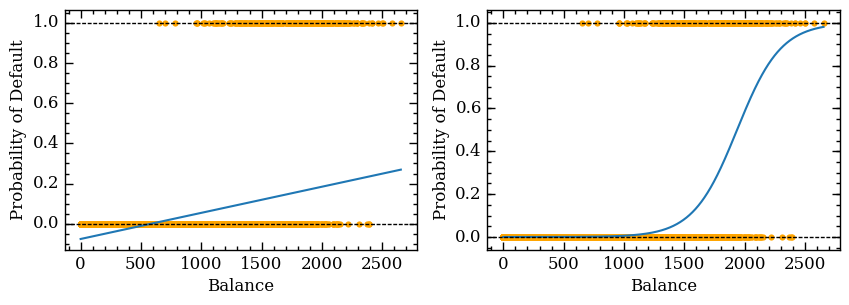

In [17]:
# Figure 4.2
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 3))

# Linear Regression
reg = linear_model.LinearRegression()
reg.fit(df[['balance']],df.default2)
ax1.scatter(df.balance,df.default2, marker='o', lw=0, color='orange',facecolors=None)
ax1.plot(X_test, reg.predict(X_test))
for i in (0,1): ax1.axhline(i, color='k', ls='dashed', lw=1)

# Logistic Regression
logr = linear_model.LogisticRegression(solver='newton-cg')
logr.fit(df[['balance']],df.default2)
ax2.scatter(df.balance,df.default2, marker='o', lw=0, color='orange',facecolors=None)
ax2.plot(X_test, logr.predict_proba(X_test)[:,1])
for i in (0,1): ax2.axhline(i, color='k', ls='dashed', lw=1)
for axs in (ax1,ax2):
    axs.set_xlabel('Balance')
    axs.set_ylabel('Probability of Default')    

In [7]:
proba = logr.predict_proba(df[['balance']])
pred = logr.predict(df[['balance']])
print 'Average probability over training:\t'+str(proba[:,1].mean())
print 'Overall proportion of defaulters:\t'+str(df.default2.sum()/float(len(df)))

Average probability over training:	0.0333000082998
Overall proportion of defaulters:	0.0333


In [73]:
import scipy as sc
class LogisticRegression(linear_model.LogisticRegression):
    def __init__(self,*args,**kwargs):
        """
        Logistic Regression with Stats output
        """
        super(LogisticRegression,self).__init__(*args,**kwargs)

    def fit_stats(self,X,y):
        self.fit(X,y)
        self.params = np.append(self.intercept_,self.coef_)
        predictions = self.predict_proba(X)
        likelihood = np.multiply(predictions[:,0], predictions[:,1])
        newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
        # V is p*(1-p)
        V = np.matrix(np.zeros(shape = (newX.shape[0], newX.shape[0])))
        np.fill_diagonal(V, likelihood)
        #covariance = XT * V * X
        covLogit = np.linalg.inv((newX.T).dot(V).dot(newX))
        self.StdErr = np.sqrt(np.diag(covLogit))
        self.tValues = self.params/self.StdErr
        self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(len(newX)-1))) for i in self.tValues]
        self.confInt = [self.params-1.95996398*self.StdErr, self.params+1.95996398*self.StdErr]
        myDF = pd.DataFrame(index=newX.columns)
        myDF["Coefs"],myDF["StdErr"],myDF["zvalues"],myDF["pvalue"] = [self.params,self.StdErr,self.tValues,self.pValues]
        myDF["[0.025"] = self.confInt[0]
        myDF["0.0975]"] = self.confInt[1]
        self.results = myDF       


In [74]:
logr1 = LogisticRegression(solver='newton-cg')
logr1.fit_stats(df[['balance']],df.default2)
logr1.results

,Coefs,StdErr,zvalues,pvalue,[0.025,0.0975]
Constant,-10.651319,0.361168,-29.491303,0.0,-11.359196,-9.943443
balance,0.005499,0.000220,24.952409,0.0,0.005067,0.005931


In [90]:
logr1 = LogisticRegression(solver='newton-cg')
logr1.fit_stats(df[['student2']],df.default2)
logr1.results

,Coefs,StdErr,zvalues,pvalue,[0.025,0.0975]
Constant,-3.502132,0.070647,-49.572430,0.000000,-3.640597,-3.363666
student2,0.399598,0.115086,3.472167,0.000518,0.174033,0.625162


In [88]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


## Multiple Logistic Regression

In [170]:
df['income1000'] = df['income']/float(1000)
multLR = LogisticRegression(solver='newton-cg', max_iter=1000)
multLR.fit_stats(df[['balance','income1000','student2']],df.default2)
multLR.results

,Coefs,StdErr,zvalues,pvalue,[0.025,0.0975]
Constant,-10.901801,0.493158,-22.106093,0.000000,-11.868374,-9.935229
balance,0.005731,0.000232,24.735501,0.000000,0.005277,0.006185
income1000,0.003962,0.008208,0.482630,0.629369,-0.012127,0.020050
student2,-0.612570,0.236394,-2.591312,0.009575,-1.075894,-0.149247


In [173]:
# Testing with scaled values
scaler = preprocessing.StandardScaler()
newdf = df[['balance','income','student2']].copy()
newdf['balance'] = scaler.fit_transform(df.balance.values.reshape(-1, 1))
newdf['income'] = scaler.fit_transform(df.income.values.reshape(-1, 1))

In [156]:
multLRscale = LogisticRegression(solver='newton-cg', max_iter=1000)
multLRscale.fit_stats(newdf,df.default2)
multLRscale.results

,Coefs,StdErr,zvalues,pvalue,[0.025,0.0975]
Constant,-5.931615,0.191219,-31.020032,0.000000,-6.306397,-5.556833
balance,2.737978,0.110560,24.764709,0.000000,2.521285,2.954671
income,0.052377,0.109055,0.480284,0.631036,-0.161366,0.266121
student2,-0.601748,0.235447,-2.555768,0.010610,-1.063216,-0.140280


## Confounding

In [143]:
conf1 = df.loc[df['student']=='Yes',['balance','default2']]
conf2 = df.loc[df['student']=='No',['balance','default2']]
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

lr1 = LogisticRegression(solver='newton-cg')
lr1.fit(conf1[['balance']],conf1['default2'])
proba1 = lr1.predict_proba(X_test)

lr2 = LogisticRegression(solver='newton-cg')
lr2.fit(conf2[['balance']],conf2['default2'])
proba2 = lr2.predict_proba(X_test)

Pstudent = conf1['default2'].sum()/float(len(conf1))
Pnonstudent = conf2['default2'].sum()/float(len(conf2))

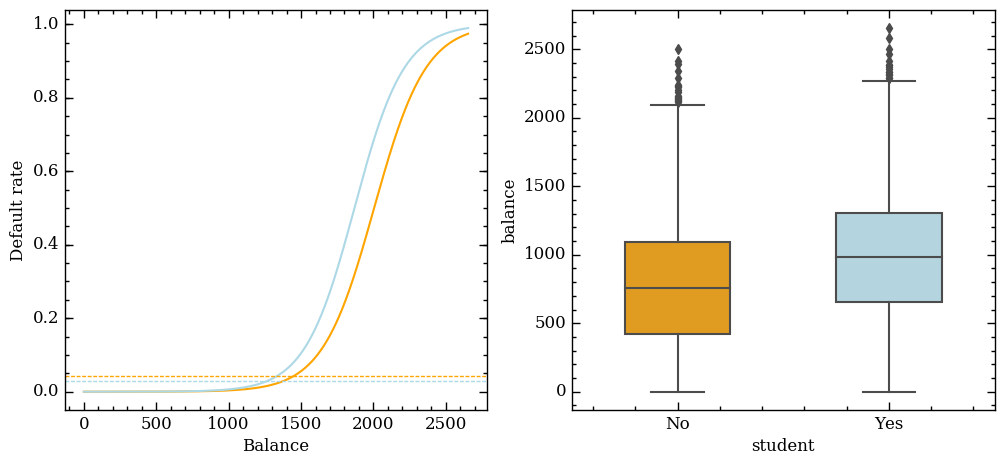

In [154]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(X_test, proba1[:,1], color='orange', label='Student')
ax1.plot(X_test, proba2[:,1], color='lightblue', label='Non-student')
ax1.axhline(Pstudent, color='orange', ls='dashed', lw=1)
ax1.axhline(Pnonstudent, color='lightblue', ls='dashed', lw=1)
ax1.set_xlabel("Balance")
ax1.set_ylabel("Default rate")
c_palette = {'Yes':'lightblue', 'No':'orange'}
sns.boxplot('student', 'balance', data=df, width=0.5, orient='v', ax=ax2,  palette=c_palette)

In [171]:
# Examples:
bbb = multLR.predict_proba([[1500.0,40.0,1],[1500.0,40.0,0]])
bbb[:,1]

array([ 0.05952455,  0.10457195])

## Linear Discriminant Analysis

In [176]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_recall_fscore_support as score

- **Precision**: When a positive value is predicted, how often is the prediction correct? How "precise" is the classifier when predicting positive instances?$$precision = \frac{TP}{(FP + TP)}$$


- **Recall** same as **True positive rate** or **sensitivity**: When the actual value is positive, how often is the prediction correct? How "sensitive" is the classifier to detecting positive instances? In our case the fraction of the defaulters that are correctly identified.$$recall = \frac{TP}{(FN + TP)}$$


- **False positive rate** (*Type 1 errors*): When the actual value is negative, how often is the prediction incorrect? In our case the fraction of the non-defaulters that we classified incorrectly as defaulter $$False~positive~rate = \frac{FP}{(TN + FP)}$$

- **Specificity**: When the actual value is negative, how often is the prediction correct? How "specific" (or "selective") is the classifier in predicting positive instances? $$specificity = \frac{TN}{(TN + FP)} = 1 - FPR$$


- **A Type 1 Error** is rejecting the null hypothesis when H0 is actually true. Here the Null hypothesis H0 is individual default, and Ha does not. Type 1 Error is then FPR and Type 2 error is (1 - TPR)

- **A Type 2 Error** is failing to reject the null hypothesis when the alternative is actually true.

In [238]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(df[['balance','income1000','student2']],df.default2)
y_pred = lda.predict(df[['balance','income1000','student2']])

# diagnostic test
precision, recall, fscore, support = score(df.default2, y_pred)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
# Confusion matrix
pd.crosstab(y_pred, df.default2, rownames=['Predicted'], colnames=['True'], margins=True)

precision: [ 0.97434084  0.78217822]
recall: [ 0.99772422  0.23723724]
fscore: [ 0.9858939  0.3640553]
support: [9667  333]


True,0,1,All
Predicted,,,
0,9645,254,9899
1,22,79,101
All,9667,333,10000


In [239]:
y_proba = lda.predict_proba(df[['balance','income1000','student2']])
y_pred = y_proba[:,1] > 0.2
#res = pd.DataFrame({'True':df.default2, 'Predicted':y_pred})
precision, recall, fscore, support = score(df.default2, y_pred)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
# Confusion matrix
pd.crosstab(df.default2.map({0:'False', 1:'True'}),y_pred,  colnames=['Predicted'], rownames=['True'], margins=True)

precision: [ 0.98537859  0.45411765]
recall: [ 0.97600083  0.57957958]
fscore: [ 0.98066729  0.50923483]
support: [9667  333]


Predicted,False,True,All
True,,,
False,9435,232,9667
True,140,193,333
All,9575,425,10000


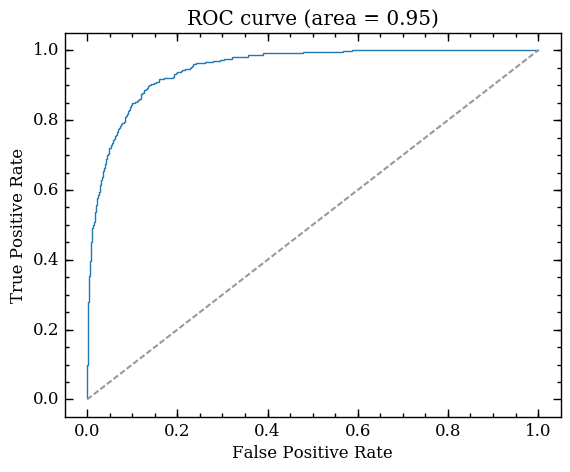

In [237]:
# ROC curve : sensitivity and 1 - specificity of our classifier
#from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df.default2,y_proba[:,1]) 

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
plt.title('ROC curve (area = %0.2f)' % (roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Lab : Logistic regression, LDA, QDA, KNN
## The stock market data

In [240]:
Smarket = pd.read_csv('Data/Smarket.csv', index_col=0, parse_dates=True)

In [251]:
Smarket.head(5)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction1
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


In [250]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction1
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,0.518400
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,0.499861
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,0.000000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,0.000000
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,1.000000
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,1.000000
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000,1.000000


In [244]:
# Paairwise correlations among predictor
Smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


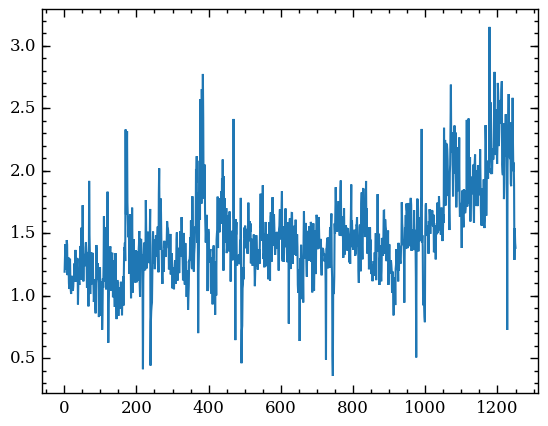

In [248]:
plt.plot(Smarket.Volume)

In [249]:
Smarket['Direction1'] = Smarket['Direction'].map({'Up':1, 'Down':0})

In [263]:
# Logistic regression
smLR = LogisticRegression(solver='newton-cg', max_iter=1000)
smLR.fit_stats(Smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']], Smarket.Direction1)
smLR.results

,Coefs,StdErr,zvalues,pvalue,[0.025,0.0975]
Constant,-0.121079,0.240720,-0.502986,0.615063,-0.592882,0.350724
Lag1,-0.072844,0.050166,-1.452066,0.146734,-0.171167,0.025479
Lag2,-0.042235,0.050085,-0.843273,0.399237,-0.140400,0.055929
Lag3,0.011016,0.049938,0.220597,0.825442,-0.086860,0.108892
Lag4,0.009284,0.049973,0.185773,0.852653,-0.088662,0.107229
Lag5,0.010263,0.049511,0.207298,0.835811,-0.086776,0.107303
Volume,0.132108,0.158347,0.834299,0.404272,-0.178245,0.442462


In [301]:
sm_proba = smLR.predict_proba(Smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
# Print the first 10 probability
print sm_proba[:10,1]
print

sm_pred = sm_proba[:,1] > 0.5

# diagnostic test
precision, recall, fscore, support = score(Smarket.Direction1, sm_pred)
# Finding accuracy score
accuracy = accuracy_score(sm_pred, Smarket.Direction1)
print('precision: {}'.format(precision[1]))
print('recall   : {}'.format(recall[1]))
print('fscore   : {}'.format(fscore[1]))
print('support  : {}'.format(support[1]))
print "accuracy : {}".format(accuracy)
# Confusion matrix
pd.crosstab(sm_pred, Smarket.Direction1.map({0:'False', 1:'True'}),rownames=['Predicted'], colnames=['True'], margins=True)

[ 0.5073437   0.48174499  0.48129808  0.51534949  0.5109914   0.5070647
  0.49274928  0.50927902  0.51783316  0.48909461]

precision: 0.525388601036
recall   : 0.782407407407
fscore   : 0.628642281463
support  : 648
accuracy : 0.5208


True,False,True,All
Predicted,,,
False,144,141,285
True,458,507,965
All,602,648,1250


In [302]:
# Test error
train = Smarket[Smarket.Year<2005]
test = Smarket[Smarket.Year>=2005]

In [304]:
# Using only Year < 2005 as a train dataset 
smLR1 = LogisticRegression(solver='newton-cg', max_iter=1000)
smLR1.fit_stats(train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']], train.Direction1)
smLR1.results

,Coefs,StdErr,zvalues,pvalue,[0.025,0.0975]
Constant,0.182594,0.333671,0.547229,0.584344,-0.471388,0.836577
Lag1,-0.054102,0.051784,-1.044761,0.296387,-0.155596,0.047393
Lag2,-0.045594,0.051795,-0.880272,0.378924,-0.147110,0.055923
Lag3,0.007278,0.051643,0.140925,0.887958,-0.093941,0.108496
Lag4,0.006539,0.051704,0.126479,0.899379,-0.094799,0.107878
Lag5,-0.004159,0.051137,-0.081322,0.935202,-0.104385,0.096068
Volume,-0.109954,0.239605,-0.458896,0.646409,-0.579571,0.359663


In [306]:
sm_pred = smLR1.predict(test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
# diagnostic test
precision, recall, fscore, support = score(test.Direction1, sm_pred)
# Finding accuracy score
accuracy = accuracy_score(sm_pred, test.Direction1)
print('precision: {}'.format(precision[1]))
print('recall   : {}'.format(recall[1]))
print('fscore   : {}'.format(fscore[1]))
print('support  : {}'.format(support[1]))
print "accuracy : {}".format(accuracy)
# Confusion matrix
pd.crosstab(sm_pred, test.Direction1.map({0:'False', 1:'True'}),rownames=['Predicted'], colnames=['True'], margins=True)

precision: 0.564705882353
recall   : 0.340425531915
fscore   : 0.424778761062
support  : 141
accuracy : 0.484126984127


True,False,True,All
Predicted,,,
0,74,93,167
1,37,48,85
All,111,141,252


In [307]:
# Only use 2 predictors with highest p-values which are lag1 and lag2
 
smLR1 = LogisticRegression(solver='newton-cg', max_iter=1000)
smLR1.fit_stats(train[['Lag1', 'Lag2']], train.Direction1)
smLR1.results

# predict
sm_pred = smLR1.predict(test[['Lag1', 'Lag2']])
# diagnostic test
precision, recall, fscore, support = score(test.Direction1, sm_pred)
# Finding accuracy score
accuracy = accuracy_score(sm_pred, test.Direction1)
print('precision: {}'.format(precision[1]))
print('recall   : {}'.format(recall[1]))
print('fscore   : {}'.format(fscore[1]))
print('support  : {}'.format(support[1]))
print "accuracy : {}".format(accuracy)
# Confusion matrix
pd.crosstab(sm_pred, test.Direction1.map({0:'False', 1:'True'}),rownames=['Predicted'], colnames=['True'], margins=True)

precision: 0.582417582418
recall   : 0.751773049645
fscore   : 0.656346749226
support  : 141
accuracy : 0.559523809524


True,False,True,All
Predicted,,,
0,35,35,70
1,76,106,182
All,111,141,252


In [320]:
# predict with lag1 = [1.2,1.5] and lag2=[1.1,0.8]
xtest = np.asarray([[1.2,1.1], [1.5,-0.8]])
smLR1.predict_proba(xtest)[:,1]

array([ 0.47922482,  0.49612601])

In [321]:
# or using dataframe
smLR1.predict_proba(pd.DataFrame({'lag1':[1.2,1.5], 'lag2':[1.1,-0.8]}))[:,1]

array([ 0.47922482,  0.49612601])

## Lab LDA

In [324]:
def print_diagtest(y, y_pred):
    # diagnostic test
    precision, recall, fscore, support = score(y, y_pred)
    # Finding accuracy score
    accuracy = accuracy_score(y_pred, y)
    print('precision: {}'.format(precision[1]))
    print('recall   : {}'.format(recall[1]))
    print('fscore   : {}'.format(fscore[1]))
    print('support  : {}'.format(support[1]))
    print "accuracy : {}".format(accuracy)
    # Confusion matrix
    display(pd.crosstab(y_pred, y,rownames=['Predicted'], colnames=['True'], margins=True))

In [331]:
smlda = LinearDiscriminantAnalysis()
smlda.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smlda.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.582417582418
recall   : 0.751773049645
fscore   : 0.656346749226
support  : 141
accuracy : 0.559523809524


True,0,1,All
Predicted,,,
0,35,35,70
1,76,106,182
All,111,141,252


## Quadratic Discriminant Analysis

In [348]:
smqda = QuadraticDiscriminantAnalysis()
smqda.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smqda.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.59900990099
recall   : 0.858156028369
fscore   : 0.705539358601
support  : 141
accuracy : 0.599206349206


True,0,1,All
Predicted,,,
0,30,20,50
1,81,121,202
All,111,141,252


**QDA** captured the true relationship more accurately than the linear forms assumed by **LDA** and **Logistic regression**

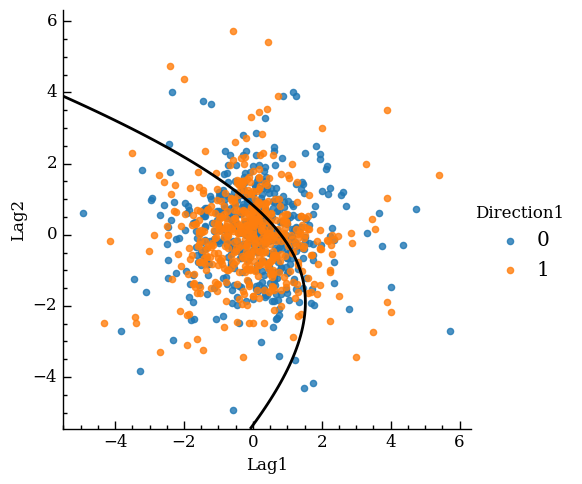

In [374]:
from matplotlib import colors
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

sns.lmplot(x='Lag1', y='Lag2', hue='Direction1', data=train, fit_reg=False)
# class 0 and 1 : areas
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
Z = smqda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
#plt.pcolormesh(xx, yy, Z, alpha=0.1,cmap='red_blue_classes', norm=colors.Normalize(0.0,1.0))
plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')
plt.show()

## K-Nearest Neighbors

In [340]:
from sklearn.neighbors import KNeighborsClassifier

In [342]:
smknn = KNeighborsClassifier(n_neighbors=1)
smknn.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smknn.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.549668874172
recall   : 0.58865248227
fscore   : 0.568493150685
support  : 141
accuracy : 0.5


True,0,1,All
Predicted,,,
0,43,58,101
1,68,83,151
All,111,141,252


In [344]:
# Change the number of Neighbors to K = 3
smknn = KNeighborsClassifier(n_neighbors=3)
smknn.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smknn.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.577181208054
recall   : 0.609929078014
fscore   : 0.593103448276
support  : 141
accuracy : 0.531746031746


True,0,1,All
Predicted,,,
0,48,55,103
1,63,86,149
All,111,141,252


In [346]:
# Change the number of Neighbors to K = 6
smknn = KNeighborsClassifier(n_neighbors=5)
smknn.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smknn.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.535947712418
recall   : 0.581560283688
fscore   : 0.557823129252
support  : 141
accuracy : 0.484126984127


True,0,1,All
Predicted,,,
0,40,59,99
1,71,82,153
All,111,141,252


Increasing K > 3 did not improve the fit. This means that the best method we got so far is the **QDA** with an accuracy of 0.599 (60%)

# Lab: Caravan Insurance Data

In [375]:
Caravan = pd.read_csv('Data/Caravan.csv')

In [376]:
Caravan.head(2)

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,No


In [382]:
Caravan.Purchase.describe()

count     5822
unique       2
top         No
freq      5474
Name: Purchase, dtype: object

In [389]:
# Standardize the data to have a zero mean and standard deviation of 1
scaler = preprocessing.StandardScaler()
Caravan_std = scaler.fit_transform(Caravan.loc[:, Caravan.columns != 'Purchase'])
test_car = Caravan_std[:1000,:]
y_test = Caravan.Purchase.values[:1000]
train_car = Caravan_std[1000:,:]
y_train = Caravan.Purchase.values[1000:]


In [390]:
carknn = KNeighborsClassifier(n_neighbors=1)
carknn.fit(train_car, y_train)
y_pred = carknn.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)

precision: 0.157142857143
recall   : 0.186440677966
fscore   : 0.170542635659
support  : 59
accuracy : 0.893


True,No,Yes,All
Predicted,,,
No,882,48,930
Yes,59,11,70
All,941,59,1000


In [391]:
# Using K=3
carknn = KNeighborsClassifier(n_neighbors=3)
carknn.fit(train_car, y_train)
y_pred = carknn.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)

precision: 0.230769230769
recall   : 0.101694915254
fscore   : 0.141176470588
support  : 59
accuracy : 0.927


True,No,Yes,All
Predicted,,,
No,921,53,974
Yes,20,6,26
All,941,59,1000


In [392]:
# Using K=5
carknn = KNeighborsClassifier(n_neighbors=5)
carknn.fit(train_car, y_train)
y_pred = carknn.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)

precision: 0.363636363636
recall   : 0.0677966101695
fscore   : 0.114285714286
support  : 59
accuracy : 0.938


True,No,Yes,All
Predicted,,,
No,934,55,989
Yes,7,4,11
All,941,59,1000


# Testing the logistic regression on the Car insurance data

In [405]:
carLR = LogisticRegression(solver='newton-cg', max_iter=1000)
carLR.fit(train_car, y_train)
y_pred = carLR.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)


precision: 0.0
recall   : 0.0
fscore   : 0.0
support  : 59
accuracy : 0.935


True,No,Yes,All
Predicted,,,
No,935,59,994
Yes,6,0,6
All,941,59,1000


Only 6 were predicted to buy car insurance and all of them are wrong